In [6]:
%matplotlib inline

import csv
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import os
import numpy as np
import math

sns.set_style('whitegrid')
mpl.rc('text', usetex=True)
sns.set_context("notebook", font_scale=1.75)

# 1.  Generate results .tsv files

In [686]:
def parse_tarball(tarball, max_k, output_filename):
    with open(output_filename, "w") as out_f:
        labels = ['instance', 'timelimit', 'restartlimit', 'vertices', 
                  'method', 'time', 'k', 'cost'] + ['cost-' + str(s) for s in range(max_k)] + \
                 ['trees'] + ['trees-' + str(s) for s in range(max_k)] + \
                 ['LB', 'UB']
        with tarfile.open(tarball) as tar:
            out_f.write("\t".join(labels) + "\n")
            for tarinfo in tar:
                filename = tarinfo.name
                if str(filename).endswith("_summary.tsv"):
                    basename = os.path.basename(filename).rstrip("_summary.tsv")
                    s = basename.split("_")
                    method = s[0]
                    k = int(s[1])
                    timelimit = "nan"
                    restartlimit = "nan"
                    if (s[2][0] != "r"):
                        timelimit = int(s[2])
                    else:
                        restartlimit = int(s[2][1:])
                    m = int(s[3][1:])
                    instance = "_".join(s[3:6])
                    ff = tar.extractfile(filename)
                    ss = str(ff.readline()).lstrip("b'").rstrip("\n'").split("\t")
                    line2 = ff.readline()
                    ss2 = str(line2).lstrip("b'").rstrip("\n'").split("\t")
                    
                    d = {}
                    d['instance'] = instance
                    d['timelimit'] = timelimit
                    d['restartlimit'] = restartlimit
                    d['vertices'] = m
                    for idx in range(len(ss)):
                        d[ss[idx]] = ss2[idx]
                        
                    # sort by number of trees
                    S = []
                    for s in range(k):
                        S.append((d['trees-%d' % s], d['cost-%d' % s]))
                    S=reversed(sorted(S))
                    for s, (trees, cost) in enumerate(S):
                        d['trees-%d' % s] = trees
                        d['cost-%d' % s] = cost
                    d['method'] = method

                    record = []
                    for label in labels:
                        if label in d:
                            record.append(d[label])
                        else:
                            record.append('nan')

                    out_f.write("\t".join(map(str, record)) + "\n")

The following commands parse tarballs containing results and generate a TSV summary file.

In [817]:
parse_tarball("results/simulations.tar.gz", 5, "results.tsv")

In [643]:
parse_tarball("results/simulations_n9_S18_k10.tar.gz", 9, "results_n9_S18_k10.tsv")

In [697]:
parse_tarball("results/tracerx_CRUK0013.tar.gz", 8, "results_tracerx_CRUK0013.tsv")
parse_tarball("results/tracerx_CRUK0037.tar.gz", 17, "results_tracerx_CRUK0037.tsv")

# 2. Plot graphs

## 2.1 Simulations

We start with reading the simulation results. We classify instances into three groups according to the number of trees they contain.

In [5]:
min_trees = 6
small = 10
big = 40

In [818]:
df = pd.read_table("results.tsv")
df = df[(df['trees'] >= min_trees)]
df['cat'] = df.apply(lambda row: "small" if row['trees'] <= small else "medium" if row['trees'] < big else "large", axis=1)
df['opt'] = df.apply(lambda row: float(row['time']) < float(row['timelimit']), axis=1)
df['norm_dist'] = df.apply(lambda row: float(row['cost']) / (2. * float(row['trees']) * (float(row['vertices']) - 1)), axis=1)
df['method_timelimit'] = df.apply(lambda row : str(row['method']) + " [" \
                                  + (str(row['timelimit']) + " s]" if float(row['restartlimit']) != 100. else str(row['restartlimit']) + " restarts]"), axis=1)

# Identify CA instances that have been solved to optimality by comparing cost to ILP cost 
# (in case ILP solved the instance to optimality)
for index, row in df.iterrows():
    if str(row['method']) == "CA":
#         print row["instance"],
#         print df[(df["instance"] == str(row["instance"])) 
#                & (df["method"] == "ILP") & (df["timelimit"] == 3600.0) & (df["k"]==2)]["opt"].iloc[0]
        if df[(df["instance"] == str(row["instance"])) & (df["cat"] == str(row["cat"]))
               & (df["method"] == "ILP") & (df["timelimit"] == 3600.0) & (df["k"]==float(row["k"]))]["opt"].iloc[0]:
            df.loc[index, "opt"] = True

nr_small = len(df[df['cat'] == "small"].instance.unique())
nr_medium = len(df[df['cat'] == "medium"].instance.unique())
nr_large = len(df[df['cat'] == "large"].instance.unique())

print "#Small instances:", nr_small
print "#Medium instances:", nr_medium
print "#Large instances:", nr_large

#Small instances: 16
#Medium instances: 15
#Large instances: 14


Generate LaTeX table with number of instances solved to optimality by each method.

In [273]:
methods = ["ILP [3600.0 s]", "BF [3600.0 s]", "CA [3600.0 s]", "CA [100.0 restarts]"]
df_count = df[df["opt"]].groupby(["method_timelimit", "k", "cat"]).count()["instance"].unstack(["cat"]).fillna(0).reset_index()
for cat in ["small", "medium", "large"]:
    print "\multirow{4}{*}{%s (%d total)} " % (cat, len(df[df['cat'] == cat].instance.unique())),
    for k in range(2,6):
        print "& %d &" % k,
#         for method in methods:
#             print df_count[(df_count["method_timelimit"] == method) & (df_count["k"] == k)][cat].iloc[0]
        print " & ".join([str(int(df_count[(df_count["method_timelimit"] == method) & (df_count["k"] == k)][cat].iloc[0])) for method in methods]),
        print "\\\\"

\multirow{4}{*}{small (16 total)}  & 2 & 16 & 16 & 16 & 16 \\
& 3 & 16 & 16 & 16 & 16 \\
& 4 & 16 & 16 & 16 & 16 \\
& 5 & 16 & 14 & 16 & 16 \\
\multirow{4}{*}{medium (15 total)}  & 2 & 15 & 13 & 15 & 15 \\
& 3 & 13 & 7 & 13 & 13 \\
& 4 & 12 & 0 & 12 & 12 \\
& 5 & 10 & 0 & 10 & 10 \\
\multirow{4}{*}{large (14 total)}  & 2 & 3 & 0 & 3 & 3 \\
& 3 & 0 & 0 & 0 & 0 \\
& 4 & 0 & 0 & 0 & 0 \\
& 5 & 0 & 0 & 0 & 0 \\


In [819]:
def plot_nr_trees(df, ax, method, instance):
    labels = list(sorted(df[(df['method_timelimit'] == method) & (df['instance'] == instance)]['k'].unique()))
    r = range(len(labels))

    df2 = df[(df['method_timelimit'] == method) & (df['instance'] == instance)]
    df2.fillna(0, inplace=True)
    
    n = df2[df2['k'] == 2]["trees"].iloc[0]

    totals = [df2[df2['k'] == s]["trees"].iloc[0] for s in labels]
    bars = [[df2[df2['k'] == s]["trees-%d" % (ss - 1)].iloc[0] for s in labels] for ss in labels]
    
    cols = sns.color_palette("Set2", 8)
    if len(labels) > 8:
        cols = cols + [cols[-1]] * (len(labels) - 8)

    # plot
    barWidth = 0.55
    bottoms = [ 0 for i in r ]
    b = []
    for i in r:
        b.append(plt.bar(labels, bars[i], bottom=bottoms, color=sns.color_palette("Paired", len(labels))[i], width=barWidth, axes=ax))
        bottoms = [i+j for i,j in zip(bottoms, bars[i])]

#     ax.legend(b, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))
    ax.set_xticks(r, labels)
    ax.set_ylabel("\#trees $n_s$ per cluster $s$")
#     ax.set_ylim((0,50))
#     ax.set_yticks(np.arange(0, 50, 10))
    ax.grid(axis="x", b=False)
#     ax.set_xticklabels(['0'] + labels)
    ax.set_xlabel("\#clusters $k$")
    ax.set_xlim((0.5,labels[-1] + 0.5))

In [820]:
def plot_cost(df, ax, method, instance):
    labels = list(sorted(df[(df['method_timelimit'] == method) & (df['instance'] == instance)]['k'].unique()))
    r = range(len(labels))
#     print(labels)

    df2 = df[(df['method_timelimit'] == method) & (df['instance'] == instance)]
    df2.fillna(0, inplace=True)
    
    n = df2[df2['k'] == 2]["trees"].iloc[0]
    m = df2[df2['k'] == 2]["vertices"].iloc[0]

    totals = [df2[df2['k'] == s]["cost"].iloc[0] for s in labels]
    bars = [[float(df2[df2['k'] == s]["cost-%d" % (ss - 1)].iloc[0]) / (n*(m-1)) for s in labels] for ss in labels]
    
    cols = sns.color_palette("Set2", 8)
    if len(labels) > 8:
        cols = cols + [cols[-1]] * (len(labels) - 8)

    # plot
    barWidth = 0.55
    bottoms = [ 0 for i in r ]
    b = []
    for i in r:
        b.append(plt.bar(labels, bars[i], bottom=bottoms, color=sns.color_palette("Paired", len(labels))[i], width=barWidth, axes=ax))
        bottoms = [i+j for i,j in zip(bottoms, bars[i])]

    ax.legend(b, labels, loc="upper left", ncol=3, bbox_to_anchor=(0.05, 1.02), title="cluster")
    ax.set_xticks(r, labels)
    ax.set_ylabel("norm.~distance $\overline{d}(\mathcal{T},\mathcal{R},\sigma)$")
    ax.set_ylim((0,1))
    ax.grid(axis="x", b=False)
#     ax.set_xlabel("\#clusters $k$")
    ax.set_xlim((0.5,labels[-1] + 0.5))
    
    dist4 = [np.log(n) * .5*s - 2 * n * np.log((1- df2[df2['k'] == s]["norm_dist"].iloc[0])) for s in labels]
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.set_ylabel("BIC value")

    tmp = plt.plot(labels, dist4, color="black", axes=ax2)
    ax2.legend(tmp, ["BIC"], loc="center right")

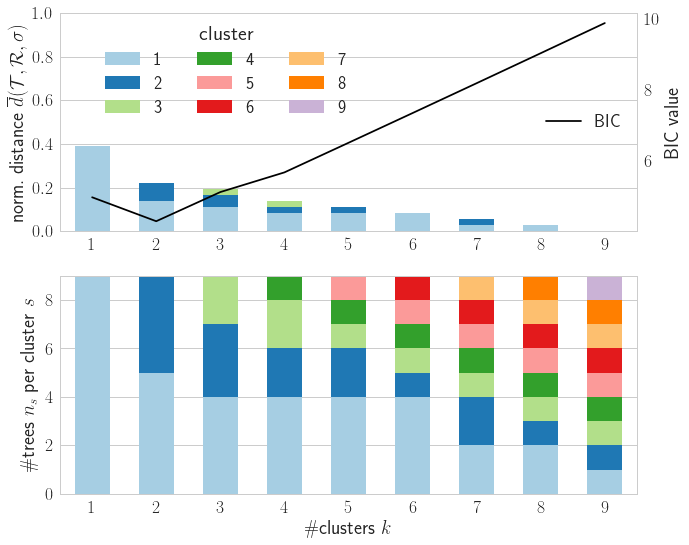

In [821]:
df_long = pd.read_table("results_n9_S18_k10.tsv")
df_long['norm_dist'] = df_long.apply(lambda row: float(row['cost']) / (2. * float(row['trees']) * (float(row['vertices']) - 1)), axis=1)
df_long['method_timelimit'] = df_long.apply(lambda row : str(row['method']) + " [" \
                                  + (str(row['timelimit']) + " s]" if float(row['restartlimit']) != 100. else str(row['restartlimit']) + " restarts]"), axis=1)
nrRows = 2
nrCols = 1
idx = 1

ax = plt.subplot(nrRows, nrCols, idx)
plot_cost(df_long, ax, "CA [100 restarts]", "n9_S18_k10")
idx += 1
ax = plt.subplot(nrRows, nrCols, idx)
plot_nr_trees(df_long, ax, "CA [100 restarts]", "n9_S18_k10")
idx += 1

plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.savefig("BIC.pdf")

## 2.2 TRACERx instances

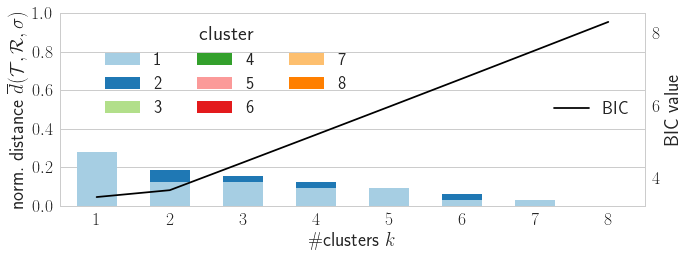

In [815]:
df_tracerx = pd.read_table("results_tracerx_CRUK0013.tsv")
df_tracerx['norm_dist'] = df_tracerx.apply(lambda row: float(row['cost']) / (2. * float(row['trees']) * (float(row['vertices']) - 1)), axis=1)
df_tracerx['method_timelimit'] = df_tracerx.apply(lambda row : str(row['method']) + " [" \
                                  + (str(row['timelimit']) + " s]" if float(row['restartlimit']) != 100. else str(row['restartlimit']) + " restarts]"), axis=1)

df_tracerx2 = pd.read_table("results_tracerx_CRUK0037.tsv")
df_tracerx2['norm_dist'] = df_tracerx2.apply(lambda row: float(row['cost']) / (2. * float(row['trees']) * (float(row['vertices']) - 1)), axis=1)
df_tracerx2['method_timelimit'] = df_tracerx2.apply(lambda row : str(row['method']) + " [" \
                                  + (str(row['timelimit']) + " s]" if float(row['restartlimit']) != 100. else str(row['restartlimit']) + " restarts]"), axis=1)



nrRows = 1
nrCols = 1
idx = 1

ax = plt.subplot(nrRows, nrCols, idx)
plot_cost(df_tracerx, ax, "CA [100 restarts]", "n9_CRUK0013")
idx += 1
ax.set_xlabel("\#clusters $k$")

plt.gcf().set_size_inches(10, 4)
plt.tight_layout()
plt.savefig("CRUK0013.pdf")

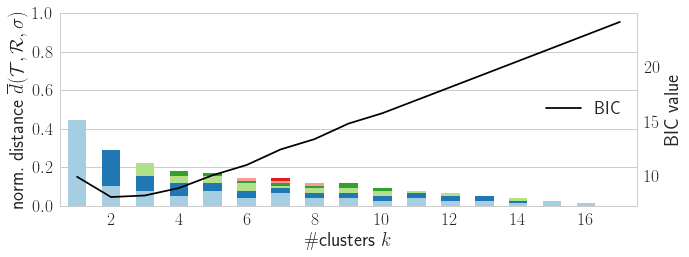

In [816]:
df_tracerx2 = pd.read_table("results_tracerx_CRUK0037.tsv")
df_tracerx2['norm_dist'] = df_tracerx2.apply(lambda row: float(row['cost']) / (2. * float(row['trees']) * (float(row['vertices']) - 1)), axis=1)
df_tracerx2['method_timelimit'] = df_tracerx2.apply(lambda row : str(row['method']) + " [" \
                                  + (str(row['timelimit']) + " s]" if float(row['restartlimit']) != 100. else str(row['restartlimit']) + " restarts]"), axis=1)

nrRows = 1
nrCols = 1
idx = 1

ax = plt.subplot(nrRows, nrCols, idx)
plot_cost(df_tracerx2, ax, "CA [100 restarts]", "n10_CRUK0037")
idx += 1
ax.legend()
ax.set_xlabel("\#clusters $k$")

plt.gcf().set_size_inches(10, 4)
plt.tight_layout()
plt.savefig("CRUK0037.pdf")

## 2.3 More simulations

In [359]:
def plot_opt(df, ax, method):
#     d = { 'small'  : len(df[df['cat'] == "small"].instance.unique()), 
#           'medium' : len(df[df['cat'] == "medium"].instance.unique()),
#           'large'  : len(df[df['cat'] == "large"].instance.unique())
#         }
    r = range(5)
    labels = ["1", "2", "3", "4", "5"]
    df2 = df[df['opt'] & (df['timelimit'] == 3600) & (df['method'] == method)]
    df2 = df2.groupby(["method", "timelimit", "k", "cat"]).count()['instance'].unstack(["cat"])
    df2 = df2.reset_index()
    df2.fillna(0, inplace=True)
#     df2['method-cat'] = df2.apply(lambda row : str(row['method']) + str(row['cat']), axis=1)
#     df2['instance'] = df2.apply(lambda row : row['instance'] / d[row['cat']], axis=1)
    
    totals = [i+j+k for i,j,k in zip(df2["small"], df2["medium"], df2["large"])]
    greenBars = [i for i,j in zip(df2["small"], totals)]
    orangeBars = [i for i,j in zip(df2["medium"], totals)]
    blueBars = [i for i,j in zip(df2["large"], totals)]
    
    # plot
    barWidth = 0.55
    # Create green Bars
    k1 = plt.bar(r, greenBars, color=sns.color_palette()[0], width=barWidth, axes=ax)
    # Create orange Bars
    k2 = plt.bar(r, orangeBars, bottom=greenBars, color=sns.color_palette()[1], 
                 width=barWidth, axes=ax)
    # Create blue Bars
    k3 = plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], 
                 color=sns.color_palette()[2], width=barWidth, axes=ax)
    ax.legend([k1,k2,k3], ["small", "medium", "large"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))
    ax.set_xticks(r, [1,3,5])
    ax.set_ylabel("\#instances solved by %s" % method)
    ax.set_ylim((0,50))
#     ax.set_yticks(np.arange(0, 50, 10))
    ax.grid(axis="x", b=False)
    ax.set_xticklabels(['0'] + labels)
    ax.set_xlabel("\#clusters $k$")

[16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 14.0]


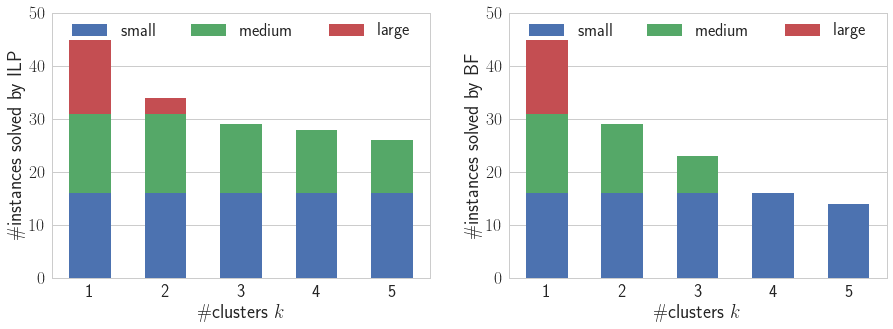

In [310]:
nrRows = 1
nrCols = 2
idx = 1

ax = plt.subplot(nrRows, nrCols, idx)
plot_opt(df, ax, "ILP")
idx += 1
ax = plt.subplot(nrRows, nrCols, idx)
plot_opt(df, ax, "BF")

plt.gcf().set_size_inches(13, 5) 
plt.tight_layout()
plt.savefig("opt.pdf")

In [688]:
def plot_nr_trees2(df, ax, cat, color_offset):
    df2 = df[(df['method'] == "CA") & (df['timelimit'] == 60.) & (df['k'] == 2) & (df['cat'] == cat)]
    sns.stripplot(data=df2, x="cat", y="trees", alpha=.4, split=True, linewidth=1, jitter=.1, 
                  palette=sns.color_palette()[color_offset:], ax=ax)
    sns.boxplot(data=df2, x="cat", y="trees", showfliers=False,
                     palette=sns.color_palette()[color_offset:], ax=ax)
#     ax.set(yscale="log")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:3], labels[0:3], title="", loc="upper left")
    ax.set_ylim((0, None))
    ax.set_xlabel("")
    ax.set_ylabel("\#trees $n$")

In [689]:
def plot_norm_dist2(df, ax, cat=None):
    if cat:
        df2 = df[(df['k'] > 1) & (df['cat'] == cat)]
    else:
        df2 = df[(df['k'] > 1)]
    sns.stripplot(data=df2, x="k", y="norm_dist", hue="method_timelimit",
                  alpha=.4, split=True, linewidth=1, jitter=.1,
                  hue_order=["CA [100.0 restarts]", "CA [3600.0 s]", "ILP [3600.0 s]"],
                 palette=sns.color_palette("Set2", 10), ax=ax)
    sns.boxplot(data=df2, x="k", y="norm_dist", hue="method_timelimit",
                     showfliers=False, 
                     hue_order=["CA [100.0 restarts]", "CA [3600.0 s]", "ILP [3600.0 s]"],
                     palette=sns.color_palette("Set2", 10), ax=ax)
#     ax.set(yscale="log")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:3], labels[0:3], title="")
    ax.set_ylim((0, 1))
    ax.set_xlabel("\#clusters $k$ (%s)" % cat)
    ax.set_ylabel("norm.~distance $\overline{d}(\mathcal{T},\mathcal{R},\sigma)$")

In [771]:
def plot_time(df, ax, cat=None):
    if cat:
        df2 = df[(df['k'] > 1) & (df['cat'] == cat)]
    else:
        df2 = df[(df['k'] > 1)]
    sns.stripplot(data=df2, x="k", y="time", hue="method_timelimit",
                  alpha=.4, split=True, linewidth=1, jitter=.1,
                  hue_order=["CA [100.0 restarts]", "CA [3600.0 s]", "ILP [3600.0 s]"],
                 palette=sns.color_palette("Set2", 10), ax=ax)
    sns.boxplot(data=df2, x="k", y="time", hue="method_timelimit",
                     showfliers=False, 
                     hue_order=["CA [100.0 restarts]", "CA [3600.0 s]", "ILP [3600.0 s]"],
                     palette=sns.color_palette("Set2", 10), ax=ax)
    ax.set(yscale="log")
    handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[0:3], labels[0:3], title="")
    ax.legend([])
#     ax.set_ylim((0, 1))
    ax.set_xlabel("\#clusters $k$ (%s)" % cat)
    ax.set_ylabel("time [s]")

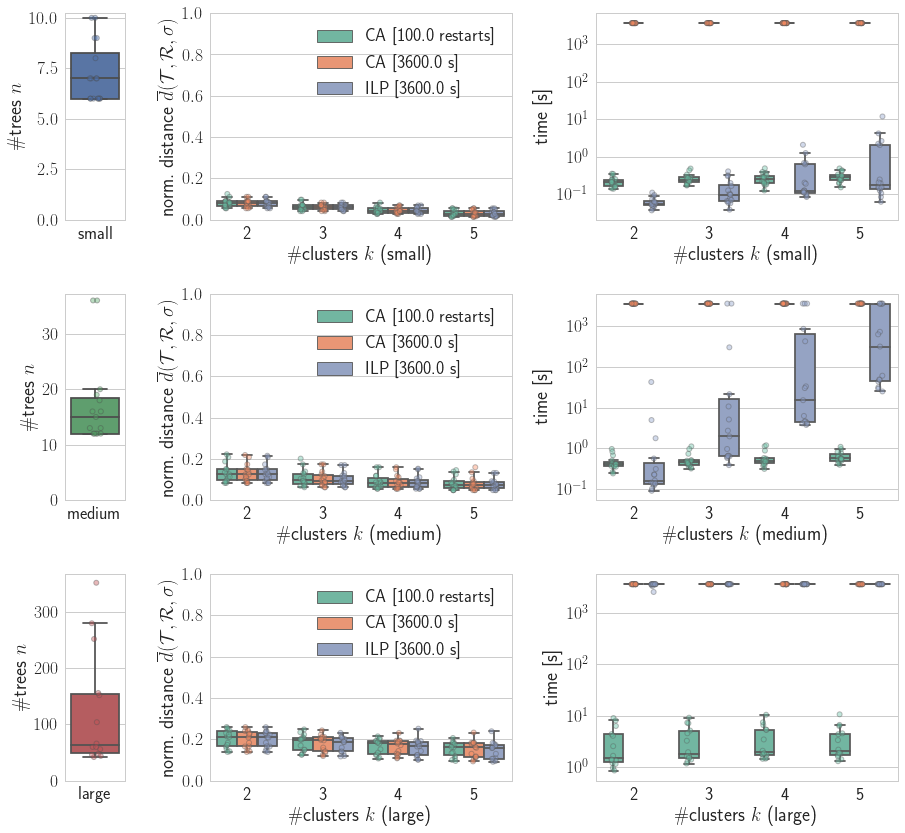

In [813]:
nrRows = 3
nrCols = 3
idx = 1

gs = mpl.gridspec.GridSpec(nrRows, nrCols, width_ratios=[1, 5, 5])
for offset, cat in enumerate(["small", "medium", "large"]):
    ax = plt.subplot(gs[idx-1])
    plot_nr_trees2(df, ax, cat, offset)
    idx += 1
    ax = plt.subplot(gs[idx-1])
    plot_norm_dist2(df, ax, cat)
    idx += 1
    ax = plt.subplot(gs[idx-1])
    plot_time(df, ax, cat)
    idx += 1

plt.gcf().set_size_inches(13, 12)
plt.tight_layout()
plt.savefig("all.pdf")

In [219]:
def plot_ilp_gap(df, ax, timelimit, cat=None):
    df2 = df[(df['method'] == 'ILP') & (df['timelimit'] == timelimit)]
    df2['gap'] = (df2['UB'] - df2['LB']) / df2['UB']
    if cat:
        df2 = df2[(df2['k'] > 1) & (df2['cat'] == cat)]
    else:
        df2 = df2[(df2['k'] > 1)]
        
    sns.stripplot(data=df2, x="k", y="gap",
                  alpha=.4, split=True, linewidth=1, jitter=.1,
                  palette=sns.color_palette("Set2", 10)[2:3], ax=ax)
    sns.boxplot(data=df2, x="k", y="gap",
                     showfliers=False,
                     palette=sns.color_palette("Set2", 10)[2:3], ax=ax)
#     ax.set(yscale="log")
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[0:3], labels[0:3], title="")
    ax.set_ylim((0, 1))
    ax.set_xlabel("\#clusters $k$ (%s)" % cat)
    ax.set_ylabel("optimality gap (UB - LB)/UB")

/Users/melkebir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


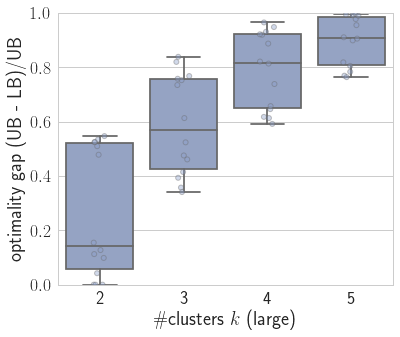

In [785]:
plot_ilp_gap(df, plt.gca(), 3600.0, "large")
plt.gcf().set_size_inches(6, 5)
plt.savefig("large_opt.pdf")

/Users/melkebir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


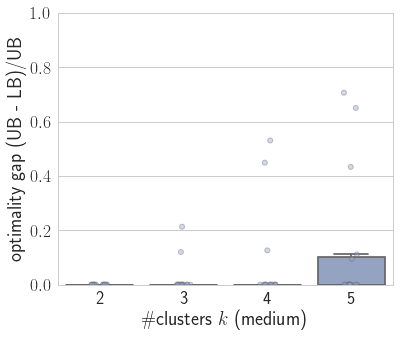

In [786]:
plot_ilp_gap(df, plt.gca(), 3600.0, "medium")
plt.gcf().set_size_inches(6, 5)
plt.savefig("medium_opt.pdf")

/Users/melkebir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


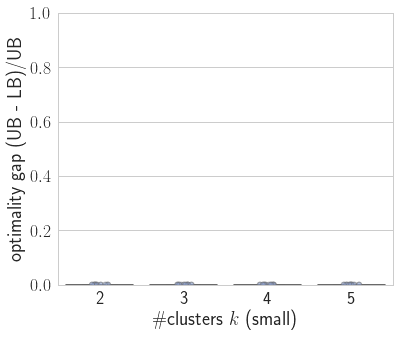

In [787]:
plot_ilp_gap(df, plt.gca(), 3600.0, "small")
plt.gcf().set_size_inches(6, 5)
plt.savefig("small_opt.pdf")

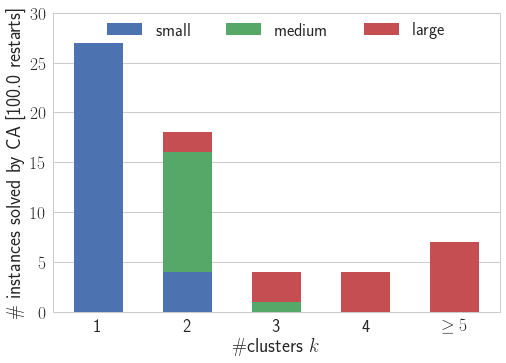

In [13]:
count = [0 for i in range(10)]
small = [0 for i in range(10)]
mid = [0 for i in range(10)]
large = [0 for i in range(10)]

instances=set([])

for pathname in glob.glob("results/simulations/CA_*_r100_*_summary.tsv"):
    filename = os.path.basename(pathname)
    instances.add(filename[10:].rstrip("_summary.tsv"))
    
for instance in instances:
    info=instance.split("_")
    m=int(info[0][1:])
    nfs=open("results/simulations/CA_1_r100_%s_clustering.txt"%(instance),"r")
    n=len(nfs.readlines())
    cost = [None for i in range(10)]
    for k in range(1,10):
        fname="results/simulations/CA_%d_r100_%s_summary.tsv"%(k,instance)
        if os.path.isfile(fname):
            ifs=open(fname,"r")
        else : break
        tmp=ifs.readline()
        tmp=ifs.readline()
        cost[k]=int(tmp.split()[3])
        ifs.close()
    bic = [.5*math.log(n)*_-2.*n*math.log(1-cost[_]/(2.*n*(m-1))) for _ in range(1,k)]
    opt_k = max( list(range(1,k)), key=( lambda x: -bic[x-1]) )
#     if opt_k>=5 : print(instance, bic,opt_k)
    count[opt_k]+=1
    if (n<=10):
        small[opt_k]+=1
    elif (n<=30):
        mid[opt_k]+=1
    else :
        large[opt_k]+=1

# print(count[1:6])
# print(small[1:6])
# print(mid[1:6])
# print(large[1:6])

r = ["1","2","3","4", '$\geq 5$']


totals = count[1:6]
greenBars = small[1:6]
orangeBars = mid[1:6]
blueBars = large[1:6]

# plot
barWidth = 0.55
# Create green Bars
k1 = plt.bar(r, small[1:6], color=sns.color_palette()[0], width=barWidth)
# Create orange Bars
k2 = plt.bar(r, mid[1:6], bottom=greenBars, color=sns.color_palette()[1], 
             width=barWidth)
# Create blue Bars
k3 = plt.bar(r, large[1:6], bottom=[i+j for i,j in zip(greenBars, orangeBars)], 
             color=sns.color_palette()[2], width=barWidth)

plt.legend([k1,k2,k3], ["small", "medium", "large"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))

plt.ylabel("\\# instances solved by CA [100.0 restarts]")
plt.ylim((0,30))
#     ax.set_yticks(np.arange(0, 50, 10))
plt.grid(axis="x", b=False)
plt.xlabel("\\#clusters $k$")
plt.savefig("counting.pdf")
